In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import glob
import pickle
from src.utils import get_cfg_from_from_ckpt_path
from sklearn.decomposition import PCA
import numpy as np
import re

from src.utils import *
from src.model.autoencoder.AE_CNN_pool_2D import AE_CNN_pool_2D
from src.model.autoencoder.AE_CNN_1D import AE_CNN_1D

In [2]:
plt.style.use('ggplot')

In [3]:
cmap = plt.get_cmap('viridis')

In [4]:
load_data = True

In [5]:
gpu = 2
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [6]:
ssf_da_path = "/DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc"
ssp_da = xr.open_dataarray(ssf_da_path).dropna(dim="lat")

coords = ssp_da.coords
depth_array = coords['z'].data


ssp_arr = ssp_da.data.transpose(0,2,3,1)
ssp_shape = ssp_arr.shape
#ssp_arr_flatten = np.flatten(ssp_arr)

In [7]:
def load_model(model_ckpt_path: str,
               device: str):

    cfg = get_cfg_from_from_ckpt_path(model_ckpt_path, pprint = False)
    
    lit_mod = hydra.utils.call(cfg.model)

    lit_mod.load_state_dict(torch.load(model_ckpt_path)["state_dict"])


    lit_mod = lit_mod.to(device) # Move model to gpu for faster inference
    lit_mod = lit_mod.eval() # Model in eval mode
    for param in lit_mod.parameters():
        param.requires_grad = False  # Ensure no gradients are calculated for this model

    return lit_mod

In [8]:
def explicit_ecs_1D(ssp: torch.tensor,
                    depth_tens: torch.tensor,
                    tau = 100):
    
    ssp = ssp.unsqueeze(1).nan_to_num()          # This operation might be unnecessary if ssp already has the correct shape
    kernel = torch.tensor([-1.0, 1.0]).float().view(1, 1, 2).to(ssp.device)
    derivative = F.conv1d(ssp, kernel, padding=0)

    sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()

    sign_diff = F.conv1d(sign, kernel, padding=1)
    sign_change = F.tanh(10 * F.relu(-sign_diff))

    for pattern in ([1, 0, 1], [1, -1, 0, 0]):
        n = len(pattern)
        kernel_matrix = torch.eye(n)
        element_match = 0
        for i in range(n):
            kernel_element = kernel_matrix[i, :].view(1, 1, n).to(ssp.device)
            element_match += (F.conv1d(sign, kernel_element, padding=0) - pattern[i]) ** 2

        # Adjust padding to match the length of sign_change
        pattern_recognition = F.pad(element_match, (1, sign_change.shape[2] - element_match.shape[2] - 1), value=1.0)
        mask_discontinuity = 1 - F.relu(pattern_recognition + 1) * F.relu(1 - pattern_recognition)

        sign_change = sign_change * mask_discontinuity

    mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

    # Expand and align depth_array with the reduced shape of the input tensor
     
    depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1).to(ssp.device).type(sign_change.dtype)
    depth_array_tens[0, 0] = 0.0  # TODO: Handle the first depth value properly

    ecs_pred = (sign_change * mask).squeeze(dim=1)
    ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values
    return ecs_pred

In [9]:

#ckpt_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_1D/pred_1_ecs_0/channels_list_[1, 1]_n_conv_per_layer_1_linear_layer_False_pooling_None_dropout_0/act_fn_None_final_act_fn_Sigmoid_normalization_min_max/manage_nan_suppress/n_profiles_100000/lr_0.01/2024-09-02_20-56/checkpoints/val_loss=0.00-epoch=472.ckpt"
ckpt_path = "/DATASET/envs/o23gauvr/outputs/AE_V2/AE_CNN_3D/pred_1_grad_0/channels_list_[1, 1]_1_conv_per_layer_padding_linear_pooling_None_final_upsample_upsample_pooling/act_fn_None_final_act_fn_Sigmoid_normalization_min_max/manage_nan_suppress/n_profiles_None/lr_0.001/2024-09-16_23-22/checkpoints/val_loss=0.00-epoch=1999.ckpt"
print(ckpt_path)

/DATASET/envs/o23gauvr/outputs/AE_V2/AE_CNN_3D/pred_1_grad_0/channels_list_[1, 1]_1_conv_per_layer_padding_linear_pooling_None_final_upsample_upsample_pooling/act_fn_None_final_act_fn_Sigmoid_normalization_min_max/manage_nan_suppress/n_profiles_None/lr_0.001/2024-09-16_23-22/checkpoints/val_loss=0.00-epoch=1999.ckpt


In [10]:
match = re.search(r"latent_dim_(\d+)", ckpt_path)

# Extract the number
if match:
    n_components = int(match.group(1))

else:
    n_components = 9

In [11]:
cfg = get_cfg_from_from_ckpt_path(ckpt_path, pprint = True)

```yaml

datamodule:
  _target_: src.autoencoder_datamodule.AutoEncoderDatamodule_${dimensions}
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 4}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssp_da, ssf_da_path: '${paths.sound}'}
  manage_nan: suppress
  n_profiles: null
  norm_stats: {method: min_max, params: '${normalization.${datamodule.norm_stats.method}}'}
dimensions: 3D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dim: '${dimensions}', dm: '${datamodule}', lit_mod: '${model}',
  trainer: '${trainer}'}
model:
  _target_: src.autoencoder_V2.AutoEncoder
  depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
  dim: ${dimensions}
  loss_weight: {ecs_weight: 0, gradient_weight: 0, max_position_weight: 0, prediction_weight: 1,
    variation_weight: 0}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  opt_fn: {T_max: 100000, _partial_: true, _target_: src.ecs_classification.ECS_classification.cosanneal_lr_adamw,
    lr: 0.001, weight_decay: 0}
model_architecture: AE_CNN
model_config:
  accumulate_grad_batches: {1D: 1, 2D: 1, 3D: 2}
  batch_size: {1D: 512, 2D: 32, 3D: 4}
  model_hparams:
    AE_CNN_1D:
      act_fn_str: None
      channels_list: [1, 1]
      dropout_proba: 0
      dtype_str: ${dtype}
      final_act_fn_str: Sigmoid
      final_upsample_str: upsample_pooling
      latent_size: 9
      linear_layer: false
      n_conv_per_layer: 1
      padding: linear
      pooling: None
    AE_CNN_2D:
      act_fn_str: None
      channels_list: [1, 1]
      dropout_proba: 0
      dtype_str: ${dtype}
      final_act_fn_str: Sigmoid
      final_upsample_str: upsample_pooling
      latent_size: 100
      linear_layer: false
      n_conv_per_layer: 1
      padding: linear
      pooling: None
    AE_CNN_3D:
      act_fn_str: None
      channels_list: [1, 1]
      dropout_proba: 0
      dtype_str: ${dtype}
      final_act_fn_str: Sigmoid
      final_upsample_str: upsample_pooling
      latent_size: 100
      linear_layer: false
      n_conv_per_layer: 1
      padding: linear
      pooling: None
  save_dir: {AE_CNN: 'channels_list_${model.model_hparams.channels_list}_${model.model_hparams.n_conv_per_layer}_conv_per_layer_padding_${model.model_hparams.padding}_pooling_${model.model_hparams.pooling}_final_upsample_${model.model_hparams.final_upsample_str}/act_fn_${model.model_hparams.act_fn_str}_final_act_fn_${model.model_hparams.final_act_fn_str}_normalization_${datamodule.norm_stats.method}',
    AE_CNN_pool_1D: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}',
    AE_CNN_pool_2D: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}/act_fn_${model.model_hparams.act_fn_str}_final_act_fn_${model.model_hparams.final_act_fn_str}_normalization_${datamodule.norm_stats.method}'}
normalization:
  mean_std: {mean: null, std: null}
  mean_std_along_depth: {mean: null, std: null}
  min_max: {x_max: null, x_min: null}
paths: {sound: /DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc}
patience: 25
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, check_on_train_epoch_end: true,
    min_delta: 0.0, monitor: val_loss, patience: '${trainer.max_epochs}', verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, log_graph: false,
    name: '${model.model_name}/pred_${model.loss_weight.prediction_weight}_grad_${model.loss_weight.gradient_weight}',
    save_dir: /DATASET/envs/o23gauvr/outputs/AE_V2/, version: '${model_config.save_dir.${model_architecture}}/manage_nan_${datamodule.manage_nan}/n_profiles_${datamodule.n_profiles}/lr_${model.opt_fn.lr}/${now:%Y-%m-%d_%H-%M}'}
  max_epochs: 2000
  min_epochs: 0


```

In [12]:
dm = hydra.utils.call(cfg.datamodule) # will instantiate src.data.BaseDataModule with parameters specified in config
dm.setup(stage="fit") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api
#dm.setup(stage="test") # setup the datamodule see https://lightning.ai/docs/pytorch/stable/data/datamodule.html#lightningdatamodule-api


In [13]:
train_ssp_arr = dm.train_dataloader().dataset.input.data
train_ssp_tens = torch.tensor(train_ssp_arr).float().to(device)
input_train_shape = train_ssp_arr.shape

# test_ssp_arr = dm.test_dataloader().dataset.input.data
# test_ssp_tens = torch.tensor(test_ssp_arr).float().to(device)
# input_test_shape = test_ssp_arr.shape

In [14]:
# if dm.norm_stats.method == "mean_std_along_depth":
#         pca_components = pca_params_dict["weight"][:n_components,:]
#         pca_mean = pca_params_dict["bias"]
        
#         #output_test_decoded_pca = (np.matmul(np.matmul(test_ssp_arr.transpose(0,2,3,1).reshape(-1,input_test_shape[1])-pca_mean,pca_components.T),pca_components)+pca_mean).reshape(input_test_shape[0],input_test_shape[2],input_test_shape[3],-1).transpose(0,3,1,2)

        
# else:

pca = PCA(n_components = n_components, svd_solver = 'auto')
pca.fit(train_ssp_arr.transpose(0,2,3,1).reshape(-1,107))
    #output_test_decoded_pca =  pca.inverse_transform(pca.transform(test_ssp_arr))

PCA(n_components=9)

In [15]:
lit_model = load_model(ckpt_path, device)
#ssp_pred = lit_model(test_ssp_tens)

bottleneck_shape = lit_model.encoder.net(torch.tensor(ssp_arr[0,0,0,:],dtype=torch.float, device=lit_model.device).unsqueeze(0).unsqueeze(0)).shape

compression_rate = len(ssp_arr[0,0,0,:])/(bottleneck_shape[1]*bottleneck_shape[2])

RuntimeError: Expected 4D (unbatched) or 5D (batched) input to conv3d, but got input of size: [1, 1, 107]

In [ ]:
# with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_rmse_ecs.pkl", "rb") as file:
#     rmse_dict_ecs_per_components = pickle.load(file)    
# with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_rmse_celerity.pkl", "rb") as file:
#     rmse_dict_ssp_per_componnents = pickle.load(file)    cuments/thèse/code/FASCINATION/outputs/AE_V2/AE_CNN_1D/identity/version_0/checkpoints/val_loss=0.00-epoch=00.ckpt
    
        
# rmse_pca_per_components_dict = dict(ssp = rmse_dict_ssp_per_componnents,
#                                     ecs = rmse_dict_ecs_per_components)

In [ ]:
def norm_ssp(ssp_arr:np.array, dm):

    print(dm.norm_stats.method)

    if dm.norm_stats.method == "mean_std_along_depth":
        mean,std = dm.norm_stats.params.values()
        ssp_unorm_arr = (ssp_arr - mean.data.reshape(1,1,1,-1)/std.data.reshape(1,1,1,-1))
        
    elif dm.norm_stats.method == "mean_std":
        mean,std = dm.norm_stats.params.values()
        ssp_unorm_arr = (ssp_arr - mean)/std
    
    elif dm.norm_stats.method == "min_max":
        x_min,x_max = dm.norm_stats.params.values()
        ssp_unorm_arr = (ssp_arr - x_min)/(x_max-x_min)
        
    return ssp_unorm_arr


In [ ]:
def unorm_ssp(ssp_arr:np.array, dm):

    print(dm.norm_stats.method)

    if dm.norm_stats.method == "mean_std_along_depth":
        mean,std = dm.norm_stats.params.values()
        ssp_unorm_arr = (ssp_arr*std.data.reshape(1,1,1,-1)) + mean.data.reshape(1,1,1,-1) 
        
    elif dm.norm_stats.method == "mean_std":
        mean,std = dm.norm_stats.params.values()
        ssp_unorm_arr = ssp_arr*std + mean
    
    elif dm.norm_stats.method == "min_max":
        x_min,x_max = dm.norm_stats.params.values()
        ssp_unorm_arr =ssp_arr*(x_max-x_min) + x_min
        
    return ssp_unorm_arr


In [ ]:
t = 6
lat = 30

norm_ssp_arr = norm_ssp(ssp_arr[t,lat,:,:], dm)
norm_ssp_pca_arr_depth_lon = pca.inverse_transform(pca.transform(norm_ssp_arr))
norm_ssp_ae_arr_depth_lon = lit_model(torch.tensor(norm_ssp_arr,dtype=torch.float, device=lit_model.device)).detach().cpu().numpy()

unorm_ssp_truth_arr_depth_lon = unorm_ssp(norm_ssp_arr,dm)
unorm_ssp_pca_arr_depth_lon = unorm_ssp(norm_ssp_pca_arr_depth_lon,dm)
unorm_ssp_ae_arr_depth_lon = unorm_ssp(norm_ssp_ae_arr_depth_lon,dm)

# unorm_ssp_truth_arr_depth_lon = ssp_arr[t,lat,:,:]
# unorm_ssp_pca_arr_depth_lon = pca.inverse_transform(pca.transform(unorm_ssp_truth_arr_depth_lon))
# unorm_ssp_ae_arr_depth_lon = lit_model(torch.tensor(unorm_ssp_truth_arr_depth_lon,dtype=torch.float, device=lit_model.device)).detach().cpu().numpy()


min_max
min_max
min_max
min_max


In [ ]:
unorm_ssp_truth_arr_depth_lon

array([[1535.94075706, 1535.95882907, 1535.97945922, ..., 1500.77654118,
        1499.74975888, 1498.81444466],
       [1535.92563911, 1535.94370735, 1535.9643363 , ..., 1500.73965947,
        1499.71816148, 1498.80116414],
       [1535.88685461, 1535.90491271, 1535.92552231, ..., 1500.66597291,
        1499.65734659, 1498.73996121],
       ...,
       [1532.17831977, 1532.17129218, 1532.14138579, ..., 1495.02070901,
        1494.37618026, 1493.86267769],
       [1532.18999134, 1532.18229913, 1532.15206206, ..., 1495.23809731,
        1494.56957337, 1494.01198936],
       [1532.18935941, 1532.18108299, 1532.15050248, ..., 1495.45914871,
        1494.76444203, 1494.16038137]])

In [ ]:
coordinates = (torch.tensor(depth_array),)
ssp_gradient_truth = torch.gradient(input = torch.tensor(unorm_ssp_truth_arr_depth_lon), spacing = coordinates, dim=1)[0]
ssp_gradient_pred = torch.gradient(input = torch.tensor(unorm_ssp_ae_arr_depth_lon), spacing = coordinates, dim=1)[0]

gradient_loss =  torch.mean((ssp_gradient_truth -ssp_gradient_pred)**2)       

gradient_loss


tensor(0.0001, dtype=torch.float64)

In [ ]:
ecs_truth = explicit_ecs_1D(torch.tensor(unorm_ssp_truth_arr_depth_lon,dtype=torch.float, device=lit_model.device),torch.tensor(depth_array).float())
ecs_pred_pca = explicit_ecs_1D(torch.tensor(unorm_ssp_pca_arr_depth_lon,dtype=torch.float, device=lit_model.device),torch.tensor(depth_array).float())
ecs_pred_ae = explicit_ecs_1D(torch.tensor(unorm_ssp_ae_arr_depth_lon,dtype=torch.float, device=lit_model.device),torch.tensor(depth_array).float())

Text(0.45, 0.75, 'Sound Speed reconstruction with 9 depth components')

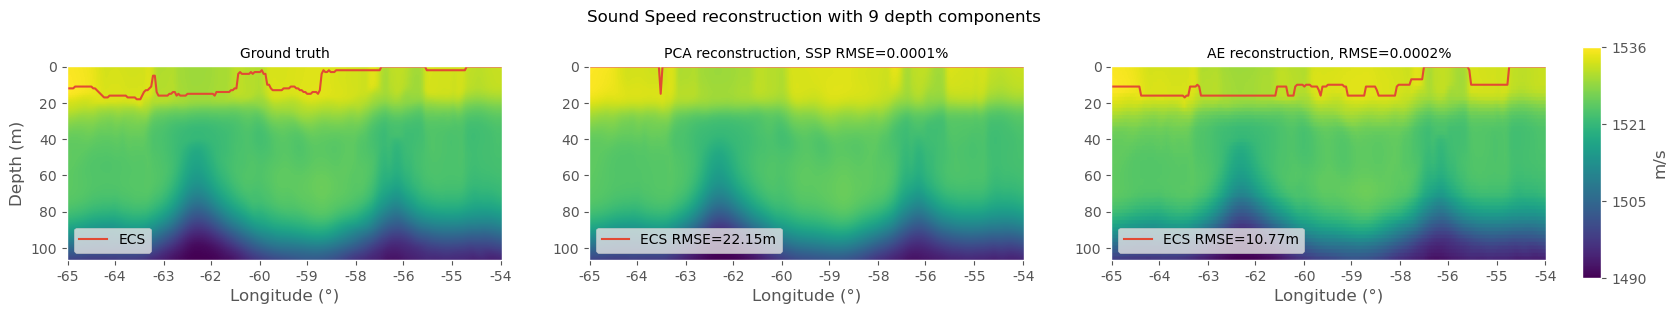

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})

im1 = axs[0].imshow(unorm_ssp_truth_arr_depth_lon.T, cmap=cmap, aspect = "equal")  
im2 = axs[1].imshow(unorm_ssp_pca_arr_depth_lon.T, cmap=cmap, aspect = "equal")
im3 = axs[2].imshow(unorm_ssp_ae_arr_depth_lon.T, cmap=cmap, aspect = "equal")


y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
y_tick_values = depth_array[y_tick_indices]

x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
x_tick_values = coords["lon"].data[x_tick_indices]

    
    
indices_ecs_truth = np.searchsorted(depth_array, ecs_truth.detach().cpu().numpy())
indices_ecs_pca = np.searchsorted(depth_array, ecs_pred_pca.detach().cpu().numpy())
indices_ecs_ae = np.searchsorted(depth_array, ecs_pred_ae.detach().cpu().numpy())


xmin, xmax = axs[0].get_xlim()

axs[0].plot(indices_ecs_truth, label = "ECS")
axs[1].plot(indices_ecs_pca, label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth-ecs_pred_pca)**2)).item(),2)}m")
axs[2].plot(indices_ecs_ae, label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth-ecs_pred_ae)**2)).item(),2)}m")

for ax in axs[:]:
    
    ax.set_xticks(x_tick_indices)
    ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
    ax.grid(False)
    
    ax.set_xlabel("Longitude (°)")
    ax.legend(loc = "lower left")
    
    #ax.invert_yaxis() 

axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title(f"PCA reconstruction, SSP RMSE={np.round(np.sqrt(np.mean((unorm_ssp_truth_arr_depth_lon-unorm_ssp_pca_arr_depth_lon)**2)/np.sum(unorm_ssp_truth_arr_depth_lon**2))*100,4)}%", fontsize = 10)
axs[2].set_title(f"AE reconstruction, RMSE={np.round(np.sqrt(np.mean((unorm_ssp_truth_arr_depth_lon-unorm_ssp_ae_arr_depth_lon)**2)/np.sum(unorm_ssp_truth_arr_depth_lon**2))*100,4)}%", fontsize = 10)

axs[0].set_ylabel('Depth (m)')


cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
cbar.set_label("m/s")

min_val, max_val = im3.get_clim()
ticks = np.linspace(min_val, max_val, 4)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

#fig.tight_layout()

fig.suptitle(f"Sound Speed reconstruction with {n_components} depth components",x = 0.45, y = 0.75)


Text(0.5, 1, 'Sound Speed Profiles reconstruction')

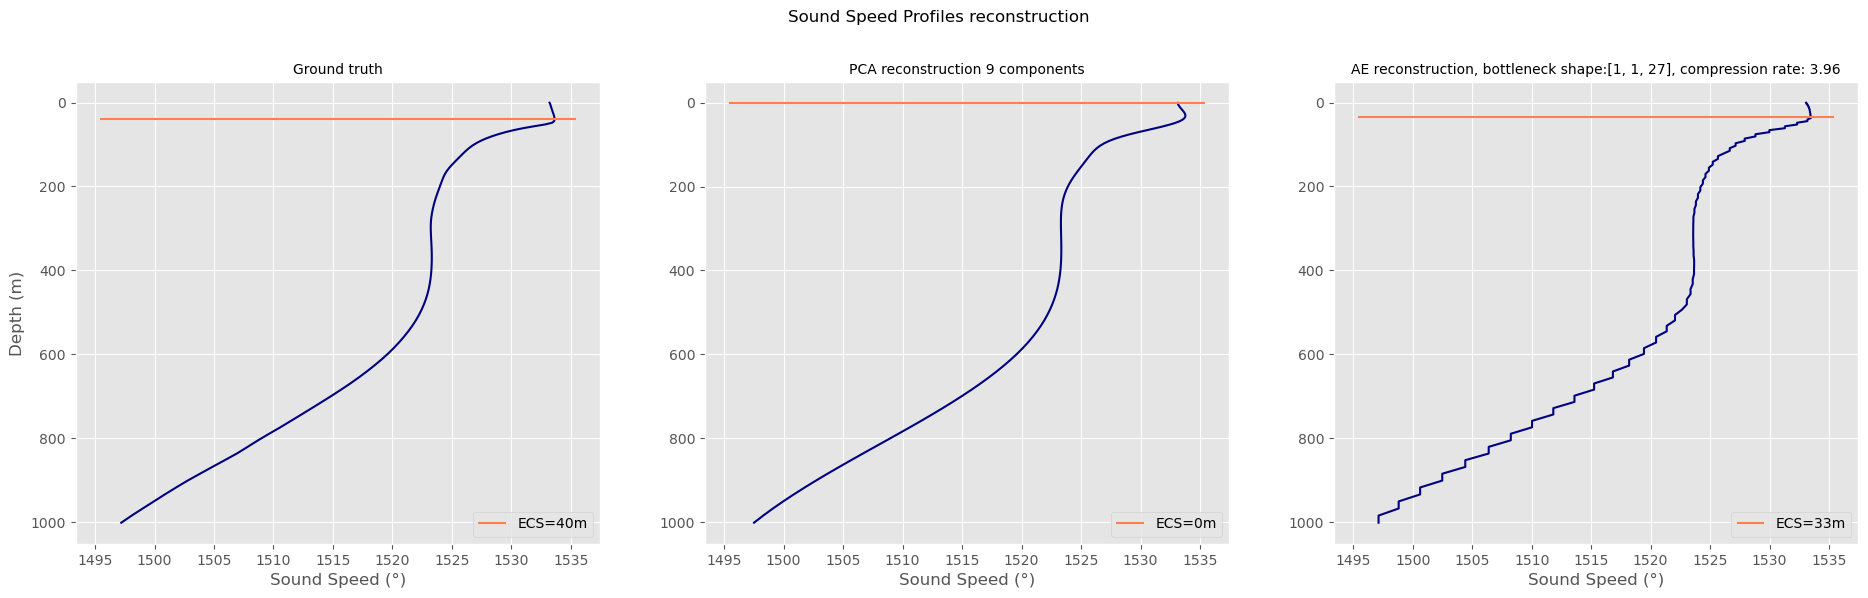

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})

lon = 20

im1 = axs[0].plot(unorm_ssp_truth_arr_depth_lon[lon,:], depth_array, c = "navy")  
im2 = axs[1].plot(unorm_ssp_pca_arr_depth_lon[lon,:], depth_array, c ="navy")
im3 = axs[2].plot(unorm_ssp_ae_arr_depth_lon[lon,:], depth_array, c="navy")


xmin, xmax = axs[0].get_xlim()
axs[0].hlines(ecs_truth[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth[lon])}m", colors = "coral")
axs[1].hlines(ecs_pred_pca[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_pca[lon])}m", colors = "coral")
axs[2].hlines(ecs_pred_ae[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae[lon])}m", colors = "coral")


for ax in axs[:]:

    ax.legend(loc = "lower right")
    ax.set_xlabel("Sound Speed (°)")
    
    ax.invert_yaxis() 
    
axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title(f"PCA reconstruction {n_components} components", fontsize = 10)
axs[2].set_title(f"AE reconstruction, bottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate,2)}", fontsize = 10)


axs[0].set_ylabel('Depth (m)')


fig.suptitle(f"Sound Speed Profiles reconstruction",x = 0.5, y = 1)

Text(0.5, 1, 'Sound Speed Profiles reconstruction in the first 170m')

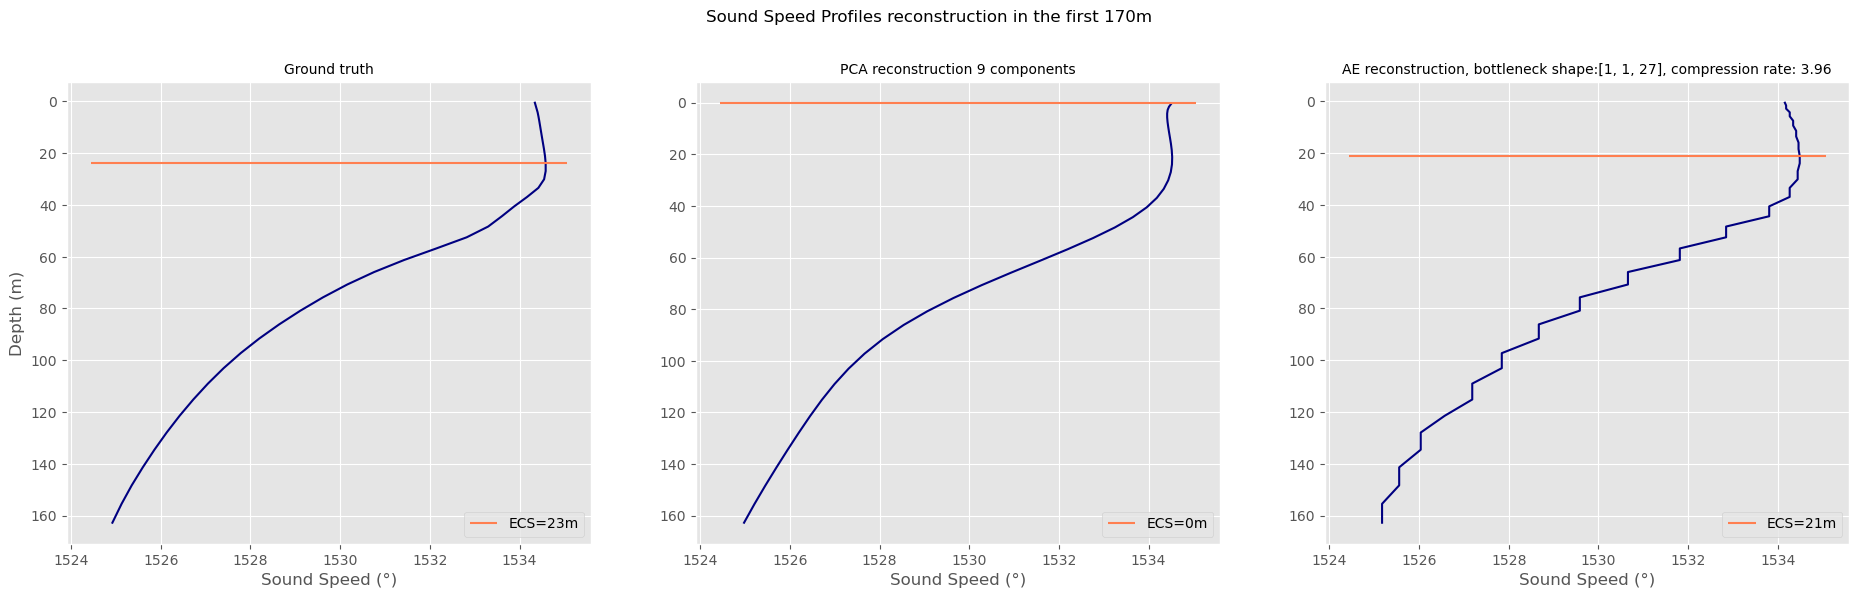

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(23,6), gridspec_kw={'width_ratios': [1, 1, 1]})

lon = 15
depth_idx = 40

im1 = axs[0].plot(unorm_ssp_truth_arr_depth_lon[lon,:depth_idx], depth_array[:depth_idx], c = "navy")  
im2 = axs[1].plot(unorm_ssp_pca_arr_depth_lon[lon,:depth_idx], depth_array[:depth_idx], c ="navy")
im3 = axs[2].plot(unorm_ssp_ae_arr_depth_lon[lon,:depth_idx], depth_array[:depth_idx], c="navy")


xmin, xmax = axs[0].get_xlim()
axs[0].hlines(ecs_truth[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_truth[lon])}m", colors = "coral")
axs[1].hlines(ecs_pred_pca[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_pca[lon])}m", colors = "coral")
axs[2].hlines(ecs_pred_ae[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae[lon])}m", colors = "coral")


for ax in axs[:]:

    ax.legend(loc = "lower right")
    ax.set_xlabel("Sound Speed (°)")
    
    ax.invert_yaxis() 
    
axs[0].set_title("Ground truth", fontsize = 10)
axs[1].set_title(f"PCA reconstruction {n_components} components", fontsize = 10)
axs[2].set_title(f"AE reconstruction, bottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate,2)}", fontsize = 10)


axs[0].set_ylabel('Depth (m)')


fig.suptitle(f"Sound Speed Profiles reconstruction in the first {int(depth_array[depth_idx])}m",x = 0.5, y = 1)

Text(0.5, 1, 'Sound Speed Profiles reconstruction in the first 170m')

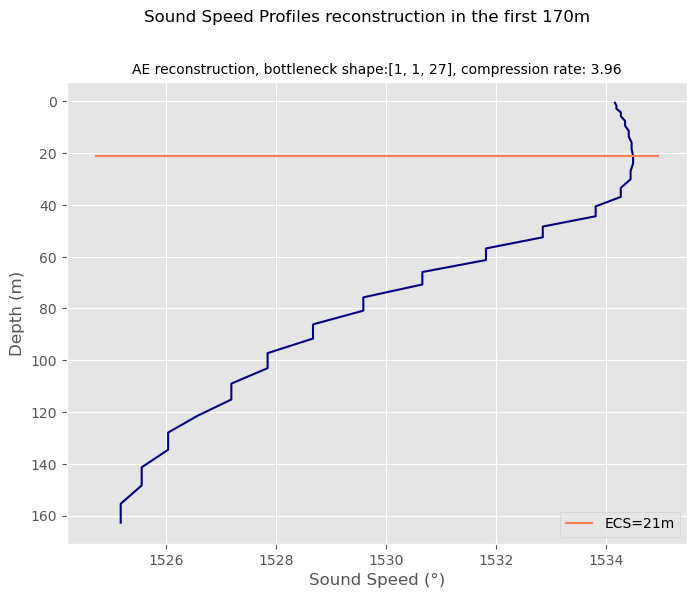

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(8,6))

lon = 15
depth_idx = 40

axs.plot(unorm_ssp_ae_arr_depth_lon[lon,:depth_idx], depth_array[:depth_idx], c="navy")


xmin, xmax = axs.get_xlim()


axs.hlines(ecs_pred_ae[lon].detach().cpu(), xmin=xmin, xmax=xmax, label = f"ECS={int(ecs_pred_ae[lon])}m", colors = "coral")




axs.legend(loc = "lower right")
axs.set_xlabel("Sound Speed (°)")

axs.invert_yaxis() 
    

axs.set_title(f"AE reconstruction, bottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate,2)}", fontsize = 10)


axs.set_ylabel('Depth (m)')


fig.suptitle(f"Sound Speed Profiles reconstruction in the first {int(depth_array[depth_idx])}m",x = 0.5, y = 1)
    

In [ ]:
# fig,axs = plt.subplots(1,2,figsize=(12,6), gridspec_kw={'width_ratios': [1, 1]})
# axs[0].plot(test_ssp_tens.detach().cpu().numpy()[t,:,lat,lon], depth_array, c = "navy")  
# axs[1].plot(ssp_truth_unorm_test_arr[t,:,lat,lon], depth_array, c = "navy")  

# axs[0].set_title("normalized", fontsize = 10)
# axs[1].set_title("unnormalized", fontsize = 10)

# for ax in axs[:]:

#     ax.legend(loc = "lower right")
#     ax.set_xlabel("Sound Speed (°)")
    
#     ax.invert_yaxis() 
    